# 如何在 JAX 中思考

<!--* freshness: { reviewed: '2024-04-08' } *-->

[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/thinking_in_jax.ipynb) [![在 Kaggle 中打开](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/google/jax/blob/main/docs/notebooks/thinking_in_jax.ipynb)

JAX 提供了一个简单而强大的 API 来编写加速的数值代码，但在 JAX 中有效地工作有时需要额外的考量。本文档旨在帮助您从基础理解 JAX 的工作原理，以便您可以更有效地使用它。


## JAX 与 NumPy

**关键概念：**

- JAX 提供了一个受 NumPy 启发的接口以便于使用。
- 通过鸭子类型，JAX 数组通常可以作为 NumPy 数组的直接替代品使用。
- 与 NumPy 数组不同，JAX 数组始终是不可变的。

NumPy 提供了一个广为人知且强大的 API 用于处理数值数据。为了方便，JAX 提供了 `jax.numpy`，该接口与 NumPy API 密切相似，并提供了便捷的 JAX 入门。几乎可以用 `numpy` 完成的任何操作都可以用 `jax.numpy` 完成：


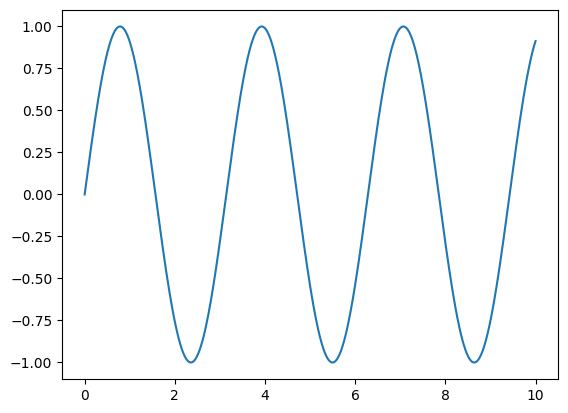

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np);


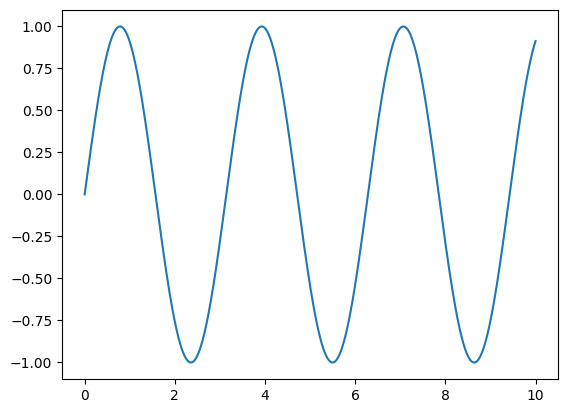

In [2]:
import jax.numpy as jnp

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp);


代码块除了将 `np` 替换为 `jnp` 外是相同的，结果也是相同的。正如我们所看到的，JAX 数组通常可以直接替代 NumPy 数组用于绘图等操作。

数组本身作为不同的 Python 类型实现：


In [3]:
type(x_np)


numpy.ndarray

In [4]:
type(x_jnp)


jaxlib.xla_extension.ArrayImpl

Python的[鸭子类型](https://en.wikipedia.org/wiki/Duck_typing)允许在许多地方交替使用JAX数组和NumPy数组。

然而，JAX和NumPy数组之间有一个重要的区别：JAX数组是不可变的，这意味着一旦创建，其内容无法更改。

以下是一个在NumPy中变更数组的示例：


In [5]:
# NumPy：可变数组
x = np.arange(10)
x[0] = 10
print(x)


[10  1  2  3  4  5  6  7  8  9]


在JAX中，等效操作会导致错误，因为JAX数组是不可变的：


In [6]:
%xmode minimal


Exception reporting mode: Minimal


In [7]:
# JAX：不可变数组
x = jnp.arange(10)
x[0] = 10


TypeError: ignored

为了更新单个元素，JAX 提供了一个 [索引更新语法](https://jax.readthedocs.io/en/latest/jax.ops.html#indexed-update-operators)，它返回一个更新后的副本：


In [8]:
y = x.at[0].set(10)
print(x)
print(y)


[0 1 2 3 4 5 6 7 8 9]
[10  1  2  3  4  5  6  7  8  9]


## NumPy, lax 和 XLA：JAX API 层次

**关键概念：**

- `jax.numpy` 是一个高级封装，提供了一个熟悉的接口。
- `jax.lax` 是一个较低级的 API，更严格且通常更强大。
- 所有 JAX 操作都是基于 [XLA](https://www.tensorflow.org/xla/)（加速线性代数编译器）中的操作实现的。


如果你查看 `jax.numpy` 的源代码，你会发现所有的操作最终都是通过在 `jax.lax` 中定义的函数来实现的。你可以将 `jax.lax` 看作是一个更严格但通常更强大的多维数组操作 API。

例如，虽然 `jax.numpy` 会隐式提升参数以允许混合数据类型之间的操作，但 `jax.lax` 不会：


In [9]:
import jax.numpy as jnp
jnp.add(1, 1.0)  # jax.numpy API 隐式地支持混合类型。


Array(2., dtype=float32, weak_type=True)

In [10]:
from jax import lax
lax.add(1, 1.0)  # jax.lax API 需要显式类型提升。


TypeError: ignored

如果直接使用 `jax.lax`，在这种情况下，您必须显式地进行类型提升：


In [11]:
lax.add(jnp.float32(1), 1.0)


Array(2., dtype=float32)

与此同时，`jax.lax` 还提供了比 NumPy 支持的更通用的操作的高效 API。

例如，考虑一维卷积，可以在 NumPy 中这样表示：


In [12]:
x = jnp.array([1, 2, 1])
y = jnp.ones(10)
jnp.convolve(x, y)


Array([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

在内部，这个NumPy操作被转换为一个更通用的卷积，由[`lax.conv_general_dilated`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.conv_general_dilated.html)实现：


In [13]:
from jax import lax
result = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float),  # 注意：明确推广
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)])  # equivalent of padding='full' in NumPy
result[0, 0]


Array([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

这是一个批量卷积操作，旨在提高在深度神经网络中常用的卷积类型的效率。它需要更多的样板代码，但比NumPy提供的卷积更灵活和可扩展（有关JAX卷积的更多详细信息，请参见 [JAX中的卷积](https://jax.readthedocs.io/en/latest/notebooks/convolutions.html)）。

从本质上讲，所有 `jax.lax` 操作都是对XLA中操作的Python封装；例如，这里的卷积实现由 [XLA:ConvWithGeneralPadding](https://www.tensorflow.org/xla/operation_semantics#convwithgeneralpadding_convolution) 提供。
每个JAX操作最终都是用这些基本的XLA操作来表示的，这使得即时编译（JIT）得以实现。


## JIT还是不JIT

**关键概念：**

- 默认情况下，JAX一次执行一个操作，按顺序进行。
- 通过使用即时编译（JIT）装饰器，可以将一序列操作一起优化并一次性运行。
- 并不是所有JAX代码都可以进行JIT编译，因为它要求数组的形状在编译时是静态且已知的。

所有JAX操作都是通过XLA来表达，这使得JAX能够利用XLA编译器高效地执行代码块。

例如，考虑这个规范化2D矩阵行的函数，它是通过`jax.numpy`操作表达的：


In [14]:
import jax.numpy as jnp

def norm(X):
  X = X - X.mean(0)
  return X / X.std(0)


可以使用 `jax.jit` 转换来创建该函数的即时编译版本：


In [15]:
from jax import jit
norm_compiled = jit(norm)


此函数返回与原始结果相同的结果，直到标准浮点精度为止：


In [16]:
np.random.seed(1701)
X = jnp.array(np.random.rand(10000, 10))
np.allclose(norm(X), norm_compiled(X), atol=1E-6)


True

但由于编译（包括操作的融合、避免分配临时数组以及其他诸多技巧），在JIT编译的情况下，执行时间可以快几个数量级（注意使用`block_until_ready()`来考虑JAX的[异步分派](https://jax.readthedocs.io/en/latest/async_dispatch.html)）：


In [18]:
%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()


815 µs ± 224 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
656 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


话虽如此，`jax.jit`确实有一些限制：特别是，它要求所有数组具有静态形状。这意味着某些JAX操作与JIT编译不兼容。

例如，此操作可以在逐操作模式下执行：


In [19]:
def get_negatives(x):
  return x[x < 0]

x = jnp.array(np.random.randn(10))
get_negatives(x)


Array([-0.10570311, -0.59403396, -0.8680282 , -0.23489487], dtype=float32)

但如果您尝试在jit模式下执行它，则会返回错误：


In [20]:
jit(get_negatives)(x)


NonConcreteBooleanIndexError: ignored

这是因为该函数生成的数组形状在编译时无法确定：输出的大小取决于输入数组的值，因此与 JIT 不兼容。


## JIT 机制：追踪和静态变量

**关键概念：**

- JIT 和其他 JAX 转换通过 *追踪* 一个函数来确定它对特定形状和类型输入的影响。

- 你不希望被追踪的变量可以标记为 *静态*

要有效使用 `jax.jit`，理解它的工作原理是很有用的。让我们在一个 JIT 编译的函数中放置一些 `print()` 语句，然后调用这个函数：


In [21]:
@jit
def f(x, y):
  print("Running f():")
  print(f"  x = {x}")
  print(f"  y = {y}")
  result = jnp.dot(x + 1, y + 1)
  print(f"  result = {result}")
  return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
f(x, y)


Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/0)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>


Array([0.25773212, 5.3623195 , 5.403243  ], dtype=float32)

注意到打印语句会执行，但它打印的不是我们传递给函数的数据，而是代表它们的*tracer*对象。

这些tracer对象是`jax.jit`用来提取由函数指定的操作序列的。基本的tracer是代表者，它们编码了数组的**形状**和**数据类型**，但与值无关。这个记录的计算序列可以在XLA中高效地应用于具有相同形状和数据类型的新输入，而无需重新执行Python代码。

当我们在匹配的输入上再次调用编译后的函数时，不需要重新编译，并且什么也不会被打印，因为结果是在编译的XLA中计算的，而不是在Python中：


In [22]:
x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
f(x2, y2)


Array([1.4344584, 4.3004413, 7.9897013], dtype=float32)

提取的操作序列编码在一个 JAX 表达式中，简称为 *jaxpr*。您可以使用 `jax.make_jaxpr` 转换来查看 jaxpr：


In [23]:
from jax import make_jaxpr

def f(x, y):
  return jnp.dot(x + 1, y + 1)

make_jaxpr(f)(x, y)


{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }

注意这一点的一个后果：因为JIT编译是在*没有*数组内容信息的情况下完成的，所以函数中的控制流语句不能依赖于被追踪的值。例如，这将失败：


In [24]:
@jit
def f(x, neg):
  return -x if neg else x

f(1, True)


TracerBoolConversionError: ignored

如果有一些变量您不希望被追踪，可以将它们标记为静态，以便于JIT编译：


In [25]:
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
  return -x if neg else x

f(1, True)


Array(-1, dtype=int32, weak_type=True)

请注意，使用不同的静态参数调用JIT编译的函数将导致重新编译，因此该函数仍然按预期工作：


In [26]:
f(1, False)


Array(1, dtype=int32, weak_type=True)

理解哪些值和操作将是静态的，哪些将被追踪，是有效使用 `jax.jit` 的关键部分。


## 静态操作与跟踪操作

**关键概念：**

- 就像值可以是静态的或被跟踪的，操作也可以是静态的或被跟踪的。

- 静态操作在Python中是在编译时评估的；被跟踪的操作是在XLA中在运行时编译和评估的。

- 对于希望保持静态的操作，请使用`numpy`；对于希望被跟踪的操作，请使用`jax.numpy`。

这种静态值与跟踪值之间的区别使得思考如何保持静态值静态变得重要。考虑这个函数：


In [27]:
import jax.numpy as jnp
from jax import jit

@jit
def f(x):
  return x.reshape(jnp.array(x.shape).prod())

x = jnp.ones((2, 3))
f(x)


TypeError: ignored

这会导致一个错误，错误信息指出找到了一个跟踪器，而不是一个具体的整数类型的一维序列。让我们在函数中添加一些打印语句，以便理解为什么会发生这种情况：


In [28]:
@jit
def f(x):
  print(f"x = {x}")
  print(f"x.shape = {x.shape}")
  print(f"jnp.array(x.shape).prod() = {jnp.array(x.shape).prod()}")
  # 注释掉这一行以避免错误：
  # 返回 x 的形状重塑为 jnp.array(x.shape).prod()。

f(x)


x = Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=1/0)>
x.shape = (2, 3)
jnp.array(x.shape).prod() = Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=1/0)>


请注意，尽管 `x` 是被跟踪的，`x.shape` 是一个静态值。然而，当我们对这个静态值使用 `jnp.array` 和 `jnp.prod` 时，它就变成了一个被跟踪的值，此时它不能在像 `reshape()` 这样需要静态输入的函数中使用（回想一下：数组的形状必须是静态的）。

一个有用的模式是对应该是静态的操作（即在编译时完成的操作）使用 `numpy`，对应该被跟踪的操作（即在运行时编译和执行的操作）使用 `jax.numpy`。对于这个函数，它可能看起来像这样：


In [29]:
from jax import jit
import jax.numpy as jnp
import numpy as np

@jit
def f(x):
  return x.reshape((np.prod(x.shape),))

f(x)


Array([1., 1., 1., 1., 1., 1.], dtype=float32)

因此，在JAX程序中，一个标准的约定是 `import numpy as np` 和 `import jax.numpy as jnp`，这样可以同时使用这两种接口，以更细致地控制操作是以静态方式（使用 `numpy`，在编译时执行一次）还是以跟踪方式（使用 `jax.numpy`，在运行时优化）进行的。
